In [1]:
date()

[1] "Wed Sep 21 19:17:11 2016"

In [2]:
sapply(c("pipeR", "ggplot2", "dplyr", "tidyr", "readr"), require, character.only = TRUE)

Loading required package: pipeR
Loading required package: ggplot2
Loading required package: dplyr
Warning message:
: package 'dplyr' was built under R version 3.3.1
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Warning message:
: package 'tidyr' was built under R version 3.3.1Loading required package: readr
Warning message:
: package 'readr' was built under R version 3.3.1

pipeR ggplot2   dplyr   tidyr   readr 
   TRUE    TRUE    TRUE    TRUE    TRUE

# 2章
## 種子数の統計モデリング

例題データ読み込み（http://hosho.ees.hokudai.ac.jp/%7Ekubo/stat/iwanamibook/fig/distribution/data.RData）

In [3]:
load("data/chap02/data.RData")

In [4]:
ls.str()

data :  num [1:50] 2 2 4 6 4 5 2 3 1 2 ...

In [5]:
data

[1] 2 2 4 6 4 5 2 3 1 2 0 4 3 3 3 3 4 2 7 2 4 3 3 3 4 3 7 5 3 1 7 6 4 6 5 2 4 7
[39] 2 2 6 2 4 5 4 5 1 3 2 3

In [6]:
length(data)

[1] 50

In [7]:
summary(data)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    2.00    3.00    3.56    4.75    7.00 

度数分布

In [8]:
table(data)

data
 0  1  2  3  4  5  6  7 
 1  3 11 12 10  5  4  4 

ヒストグラムを描く

In [9]:
options(repr.plot.width = 4, repr.plot.height = 4)

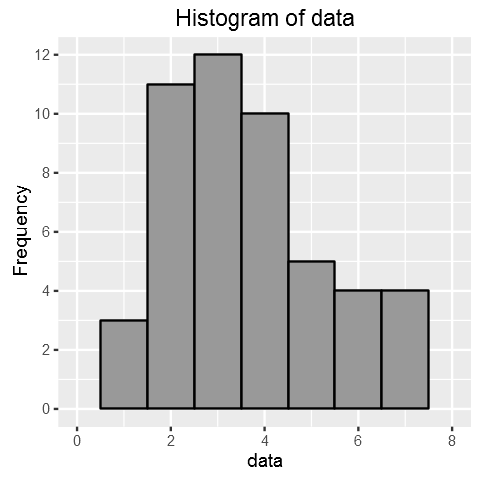

In [24]:
data_frame(data = data) %>>% 
    ggplot(aes(x = data)) + 
        geom_histogram(binwidth = 1, colour = "black", fill = gray(0.6)) + 
        ylab("Frequency") + 
        scale_y_continuous(breaks = seq(0, 12, 2)) + 
        scale_x_continuous(breaks = seq(0, 8, 2), limits = c(0, 8)) + 
        labs(title = "Histogram of data")

標本分散

In [18]:
var(data)

[1] 2.986122

標本標準偏差

In [19]:
sd(data)

[1] 1.72804

In [20]:
var(data) %>>% sqrt

[1] 1.72804

## 2.2 データと確率分布の対応関係をながめる

* 確率分布: 確率変数の値とそれが出現する確率を対応させたもの
    * ある植物個体 $i$ の種子数 $y_i$
* ポアソン分布
    * パラメータ: 分布の平均

平均 3.56 のポアソン分布は，

In [25]:
y <- 0:9
prob <- dpois(y, lambda = 3.56)

In [30]:
cbind(y, prob)

y,prob
0,0.02843882
1,0.10124222
2,0.18021114
3,0.21385056
4,0.19032700
5,0.13551282
6,0.08040427
7,0.04089132
8,0.01819664
9,0.00719778


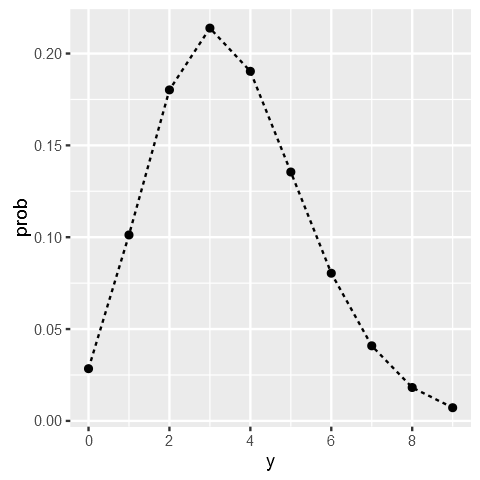

In [28]:
data_frame(y, prob) %>>% 
    ggplot(aes(y, prob)) + 
    geom_line(linetype = 2) +
    geom_point() + 
    scale_x_continuous(breaks = seq(0, 8, 2))

観測データのヒストグラムと確率分布を重ねる（確率分布 $\times$ 個体数）

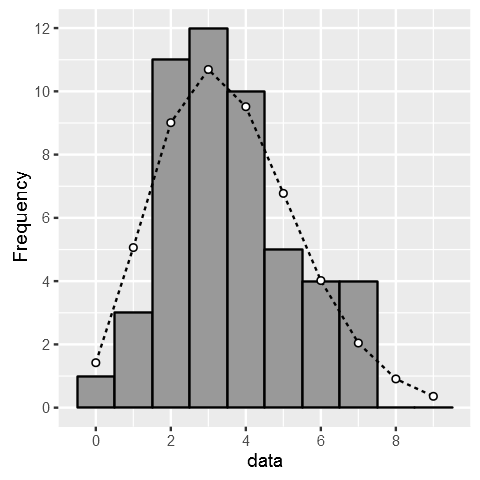

In [32]:
ggplot() + 
    geom_histogram(data = data_frame(x = data), aes(x = x), 
                   colour = "black", fill = gray(0.6), binwidth = 1) + 
    geom_line(data = data_frame(y, prob = prob * 50), aes(x = y, y = prob), linetype = 2) + 
    geom_point(data = data_frame(y, prob = prob * 50), aes(x = y, y = prob), 
               shape = 21, fill = "white") + 
    ylab("Frequency") + 
    xlab("data") + 
    scale_x_continuous(breaks = seq(0, 8, 2)) + 
    scale_y_continuous(breaks = seq(0, 12, 2))

## ポアソン分布とは何か?

定義は，

$$p(y | \lambda) = \frac{\lambda^y \exp(-\lambda)}{y!} $$

性質は，

* $\sum\limits^{\infty}_{y = 0}p(y | \lambda) = 1$
* 平均は $\lambda$
* 分散と平均は等しい

種子数のデータを表現するのにポアソン分布を選んだのは，

* 値が非負の整数
* $y_i$ に下限（0）はあるが上限はわからない
* 平均（3.56）と分散（2.99）がだいたい等しい

パラメータ $\lambda$ を変化させると，

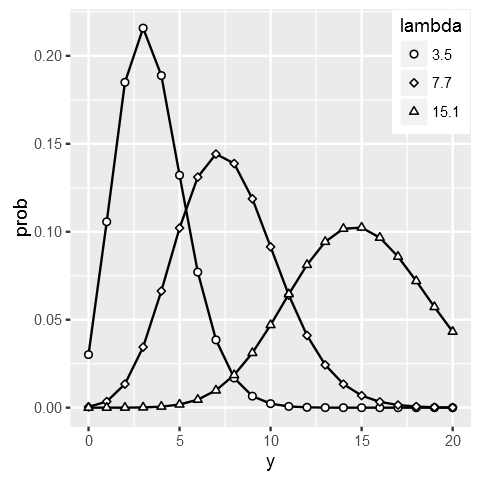

In [33]:
data_frame(x = c(0:20), y1 = dpois(x, lambda = 3.5), y2 = dpois(x, lambda = 7.7), 
           y3 = dpois(x, lambda = 15.1)) %>>%
    gather(lambda, val, -x) %>>%
    ggplot(aes(x = x, y = val, shape = lambda)) + 
    geom_line() + 
    geom_point(fill = "white") + 
    ylab("prob") + 
    xlab("y") + 
    scale_shape_manual(values = c(21, 23, 24), labels = c("3.5", "7.7", "15.1")) + 
    theme(legend.position=c(.9, .85))

## 2.4 ポアソン分布のパラメータの最尤推定

* 最尤推定
    * 尤度（当てはまりの良さ）を最大にするパラメータの値を探す
    * 尤度（$L(\lambda)$）はある$\lambda$ における $p(y_i | \lambda)$ の積 （同時確率）
    
$$ 
\begin{align}
L(\lambda) &= \prod\limits_{i}p(y_i | \lambda) \\
    &= \prod\limits_{i}\frac{\lambda^{y_i} \exp(-\lambda)}{y_i!}
\end{align}
$$

* 実際には対数尤度関数を使う

$$
\log L(y_i) = \sum\limits_{i}\left( y_i \log\lambda - \lambda - \sum\limits^{y_i}_{k}\log k \right)
$$

平均 $\lambda$ を変化させたときにポアソン分布の形状と対数尤度がどのように変化するか

In [43]:
logL <- function(m){
    dpois(data, m, log = TRUE) %>>% sum
}

In [58]:
gpPois <- function(lambda){
    gp <- ggplot() + 
    geom_histogram(data = data_frame(x = data), aes(x = x), 
                   colour = "black", fill = gray(0.6), binwidth = 1) + 
    geom_line(data = data_frame(y, prob = dpois(y, lambda = lambda) * 50), aes(x = y, y = prob), 
              linetype = 2) + 
    geom_point(data = data_frame(y, prob = dpois(y, lambda = lambda) * 50), aes(x = y, y = prob), 
               shape = 21, fill = "white") + 
    scale_x_continuous(breaks = seq(0, 8, 2)) + 
    scale_y_continuous(breaks = seq(0, 15, 5), limits = c(0, 15)) + 
    annotate(x = 6, y = 13, hjust = 0, vjust = 0, geom = "text", size = 3, 
             label = sprintf("lambda=%.1f\nlog L=%.1f", lambda, logL(lambda))) + 
    theme(axis.title = element_blank())
    return(gp)
}

In [59]:
gps <- seq(2.0, 5.2, 0.4) %>>% lapply(gpPois)

In [52]:
library(gridExtra)

Warning message:
: package 'gridExtra' was built under R version 3.3.1
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [53]:
options(repr.plot.width = 8, repr.plot.height = 8)

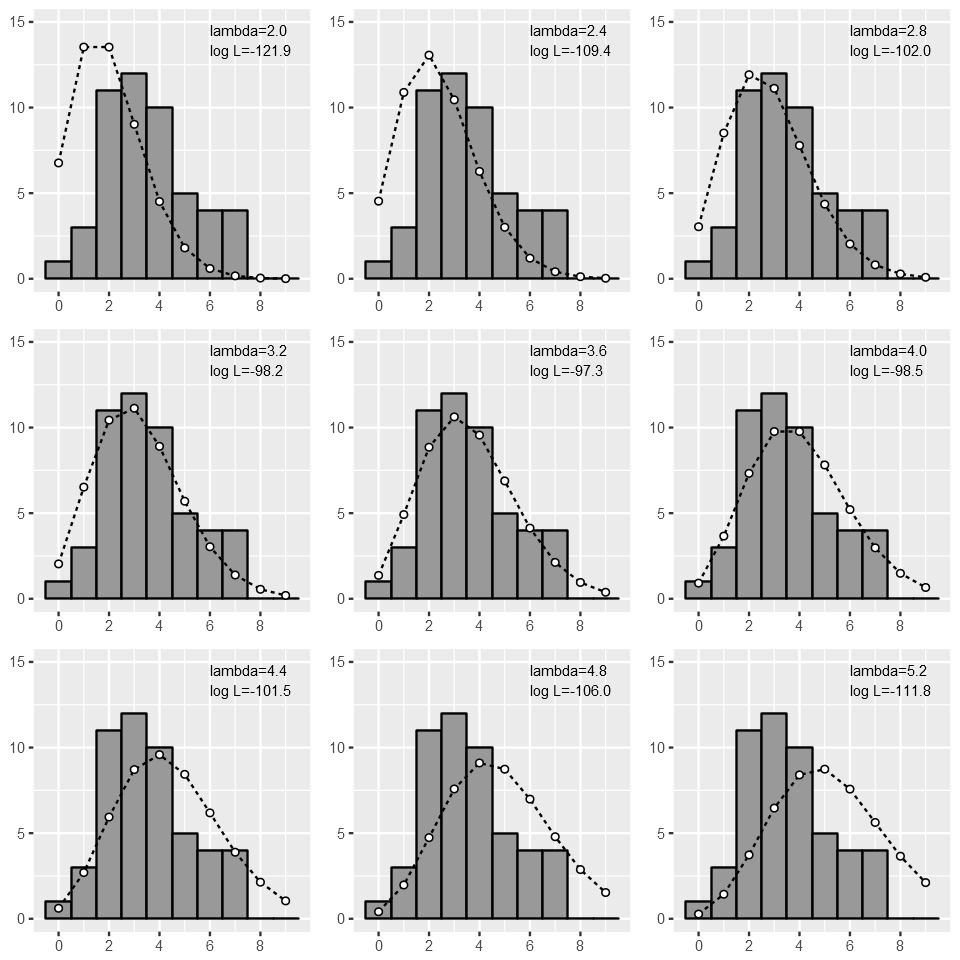

In [60]:
do.call(grid.arrange, c(gps, ncol = 3))

対数尤度と$\lambda$の関係

* 3.5ぐらいで最大

In [62]:
options(repr.plot.width = 4, repr.plot.height = 4)

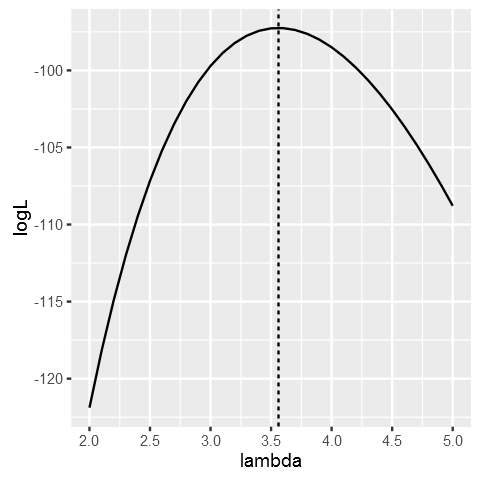

In [64]:
lambda = seq(2, 5, 0.1)
data_frame(lambda, logL = sapply(lambda, logL)) %>>% 
    ggplot(aes(x = lambda, y = logL)) + 
        geom_line() + 
        geom_vline(xintercept = 3.56, linetype = 2) + 
        scale_x_continuous(breaks = seq(2, 5, 0.5))

対数尤度が最大となる$\lambda$ を $\hat\lambda$ とする．
対数尤度関数が最大値で傾きゼロとなるとなる$\lambda$を探せばよい

$$
\begin{align}
\frac{\partial \log L(\lambda)}{\partial \lambda} &= \sum\limits_{i}\left\{ \frac{y_i}{\lambda} - 1 \right\} \\
    &= \frac{1}{\lambda}\sum\limits_{i}y_i - 50
\end{align}
$$

これが 0になるときの $\lambda$ が $\hat\lambda$ なので，解くと，
$$
\hat\lambda = \frac{1}{50}\sum\limits_{i}y_i
$$
これは標本平均のことなので $\hat\lambda = 3.56$
となる

* $\hat\lambda$: 最尤推定量
* $\hat\lambda = 3.56$: 最尤推定値


### 2.4.1 疑似乱数と最尤推定値のばらつき

推定値の標準誤差を見積もる

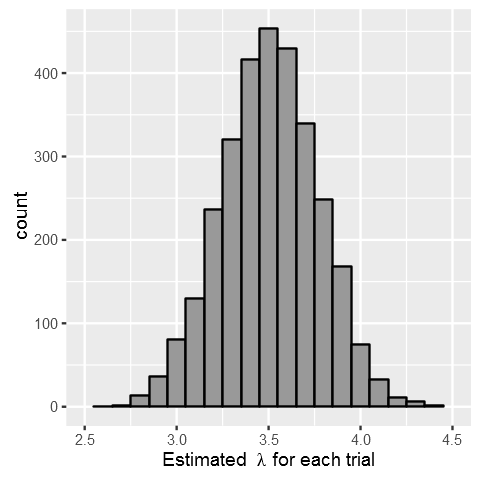

In [75]:
data_frame(y = sapply(c(1:3000), function(x){
    rpois(50, lambda = 3.5) %>>% mean
})) %>>% ggplot(aes(x = y)) + 
    geom_histogram(colour = "black", fill = gray(0.6), binwidth = 0.1) + 
    scale_x_continuous(limits = c(2.5, 4.5), breaks = seq(2.5, 4.5, 0.5)) + 
    xlab(expression("Estimated "~lambda~"for each trial"))

調査個体数が多ければ標準誤差は小さくなる

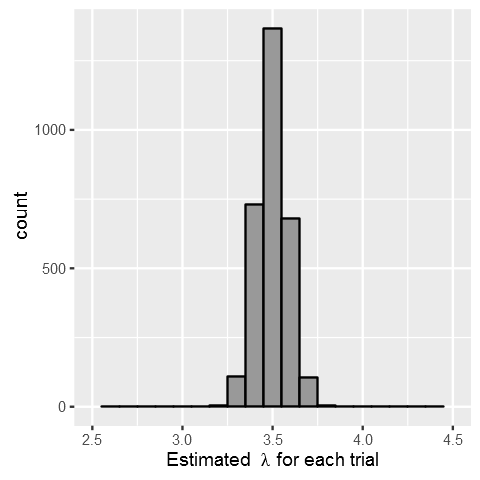

In [76]:
data_frame(y = sapply(c(1:3000), function(x){
    rpois(500, lambda = 3.5) %>>% mean
})) %>>% ggplot(aes(x = y)) + 
    geom_histogram(colour = "black", fill = gray(0.6), binwidth = 0.1) + 
    scale_x_continuous(limits = c(2.5, 4.5), breaks = seq(2.5, 4.5, 0.5)) + 
    xlab(expression("Estimated "~lambda~"for each trial"))

## 2.5 統計モデルの要点: 乱数発生・推定・予測

## 2.6 確率分布の選び方

## 2.7 まとめ

In [77]:
devtools::session_info()

Session info -------------------------------------------------------------------
Packages -----------------------------------------------------------------------


 setting  value                       
 version  R version 3.3.0 (2016-05-03)
 system   x86_64, mingw32             
 ui       RTerm                       
 language (EN)                        
 collate  Japanese_Japan.932          
 tz       Asia/Tokyo                  
 date     2016-09-21                  

 package    * version  date       source                             
 assertthat   0.1      2013-12-06 CRAN (R 3.3.0)                     
 Cairo        1.5-9    2015-09-26 CRAN (R 3.3.0)                     
 colorspace   1.2-6    2015-03-11 CRAN (R 3.3.0)                     
 crayon       1.3.2    2016-06-28 CRAN (R 3.3.1)                     
 DBI          0.5      2016-08-11 CRAN (R 3.3.1)                     
 devtools     1.12.0   2016-06-24 CRAN (R 3.3.1)                     
 digest       0.6.10   2016-08-02 CRAN (R 3.3.1)                     
 dplyr      * 0.5.0    2016-06-24 CRAN (R 3.3.1)                     
 evaluate     0.9      2016-04-29 CRAN (R 3.3.0)         